# Spatial Distribution Exercise

The goal of this tutorial is learn how to characterize what cells exist in the visual cortex volume and how they are distributed across space and cell types.

## Note if running on Google Colab

If you are running in Google colab, you will need to install a couple of packages to make it work. Just run `pip install caveclient standard_transform` in a cell at the begining of the notebook.

Also, you will have to get your token from the [CAVE website](https://global.daf-apis.com/sticky_auth/settings/tokens) and set it by passing an auth token to the CAVEclient directly via `client = CAVEclient(datastack, auth_token=auth_token)`.

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import spatial

from caveclient import CAVEclient

datastack = 'minnie65_public'
client = CAVEclient(datastack)

## Getting an overview of the cell types in the data

Download `aibs_metamodel_mtypes_v661_v2`, a table of cell type predictions throughout the dataset.
Look at the effect of the `split_positions` parameter, which can be set to True or False.

For simplicity, we will simplify the excitatory cell types in this prediction table using the pandas `replace` function, which takes a dictionary and a dataframe column and maps keys to values.
Assuming our cell type dataframe is called `soma_df`, we want to do:

```python
ct_simplify = {
    "L2a": "L2", # Layer 2 excitatory cell
    "L2b": "L2",
    "L2c": "L3", # Layer 3 excitatory cell
    "L3a": "L3",
    "L3b": "L3",
    "L4a": "L4", # Layer 4 excitatory cell
    "L4b": "L4",
    "L4c": "L4",
    "L5a": "L5it", # Layer 5 cortico-cortical (IT) cell
    "L5b": "L5it",
    "L5ET": "L5et", # Layer 5 subcortical projecting (ET) cell
    "L5NP": "L5np", # Layer 5 near projecting (NP) cell
    "L6short-a": "L6it",  # Layer 6 cortico-cortical (IT) cell
    "L6short-b": "L6it",
    "L6tall-a": "L6ct", # Layer 6 cortico-thalamic (CT) cell
    "L6tall-b": "L6ct",
    "L6tall-c": "L6ct",
}

soma_df['cell_type'] = soma_df['cell_type'].replace(ct_simplify)
```

**Tasks**:
1) Download the table and run the simplification code above to replace cell type labels.
2) Based on this table, what fraction of all neurons are inhibitory?
3) What is the most numerous excitatory cell type?

In [9]:
# split_positions=False
soma_unsplit_df = client.materialize.query_table('aibs_metamodel_mtypes_v661_v2')
soma_unsplit_df['pt_position'].head()

0     [101552, 93584, 24703]
1     [97968, 109616, 16139]
2    [101344, 104592, 15998]
3    [106224, 103968, 16013]
4    [106784, 108384, 16286]
Name: pt_position, dtype: object

In [23]:
# split_positions=True
soma_split_df = client.materialize.query_table('aibs_metamodel_mtypes_v661_v2', split_positions=True)
soma_split_df[['pt_position_x', 'pt_position_y', 'pt_position_z']].head()

# For below, we will use the split situation, which is a bit easier to handle for plotting
soma_df = soma_split_df

ct_simplify = {
    "L2a": "L2", # Layer 2 excitatory cell
    "L2b": "L2",
    "L2c": "L3", # Layer 3 excitatory cell
    "L3a": "L3",
    "L3b": "L3",
    "L4a": "L4", # Layer 4 excitatory cell
    "L4b": "L4",
    "L4c": "L4",
    "L5a": "L5it", # Layer 5 cortico-cortical (IT) cell
    "L5b": "L5it",
    "L5ET": "L5et", # Layer 5 subcortical projecting (ET) cell
    "L5NP": "L5np", # Layer 5 near projecting (NP) cell
    "L6short-a": "L6it",  # Layer 6 cortico-cortical (IT) cell
    "L6short-b": "L6it",
    "L6tall-a": "L6ct", # Layer 6 cortico-thalamic (CT) cell
    "L6tall-b": "L6ct",
    "L6tall-c": "L6ct",
}
soma_df['cell_type'] = soma_df['cell_type'].replace(ct_simplify)

In [24]:
cell_counts = soma_df.value_counts('classification_system')

# Fraction inhibitory:
cell_counts['inhibitory_neuron'] / cell_counts.sum()

0.11035505418664597

In [26]:
# Relative number of different cell types:
soma_df.query('classification_system == "excitatory_neuron"').value_counts('cell_type').sort_values()

cell_type
L5np      944
L5et     1944
L5it     4960
L6it     5837
L2       6909
L6ct    13864
L3      14146
L4      15591
Name: count, dtype: int64

## Reorienting the data

We are going to use a package called `standard_transform` to make it easier to put the data into a useful coordinate system.
The current `pt_position` values are in voxels and can be directly pasted into Neuroglancer.
However, usually for analysis we want spatial dimensions like nanometers or microns.
Moreover, it's useful if convenient directions like pia-to-white-matter axis correspond to the y-coordinate.

**Tasks**

Plot the x-y distribution of excitatory neuron cell body locations.
Note density as a function of depth, but also slight rotation of dataset.
_Hint_: The y-coordinates *increase* as you go down from pia.

Next, use the standard_transform function `minnie_ds.transform_vx.apply_dataframe( COLUMN_NAME, DATAFRAME )` that maps voxel coordinates in the column "COLUMN_NAME" of a dataframe to microns.
The transform will rotate the data by 5 degrees and align y=0 to be near the pial surface.
Plot the new x-y distribution of excitatory neuron cell body locations and see how that differs from the untransformed.

In [29]:
from standard_transform.datasets import minnie_ds

X_transformed = minnie_ds.transform_vx.apply_dataframe('pt_position', soma_df)
X_transformed = np.array(X_transformed)
soma_df['pt_um_x'] = X_transformed[:,0]
soma_df['pt_um_y'] = X_transformed[:,1]
soma_df['pt_um_z'] = X_transformed[:,2]

# Convert voxel resolutions to nanometers via the resolution of the table
soma_df['pt_position_x_nm'] = soma_df['pt_position_x'] * 4
soma_df['pt_position_y_nm'] = soma_df['pt_position_y'] * 4
soma_df['pt_position_z_nm'] = soma_df['pt_position_z'] * 40

In [32]:
# How would you have known the table resolution? Look up the table metadata

client.materialize.get_table_metadata('aibs_metamodel_mtypes_v661_v2')

{'schema': 'cell_type_reference',
 'aligned_volume': 'minnie65_phase3',
 'valid': True,
 'table_name': 'aibs_metamodel_mtypes_v661_v2',
 'created': '2023-08-22T18:09:11.554670',
 'id': 34200,
 'schema_type': 'cell_type_reference',
 'user_id': '1077',
 'description': 'This table contains Mtype predictions (Schneider-Mizell 2023) for cells throughout the entire dataset at materialization version 661. The predictions come from a soma and nucleus feature trained metamodel (Elabbady 2022). This is a reference table where id refers to the unique nucleus id in the "nucleus_detection_v0" table. Classification_system refers to the coarse class predictions (excitatory or inhibitory) and cell_type denotes neuronal mtype predictions. Errors, nonneurons, and soma-soma mergers have been filtered out. For questions please contact Leila Elabbady or Forrest Collman. [Note: This table \'aibs_metamodel_mtypes_v661_v2\' will update the \'target_id\' foreign_key when updates are made to the \'nucleus_detec

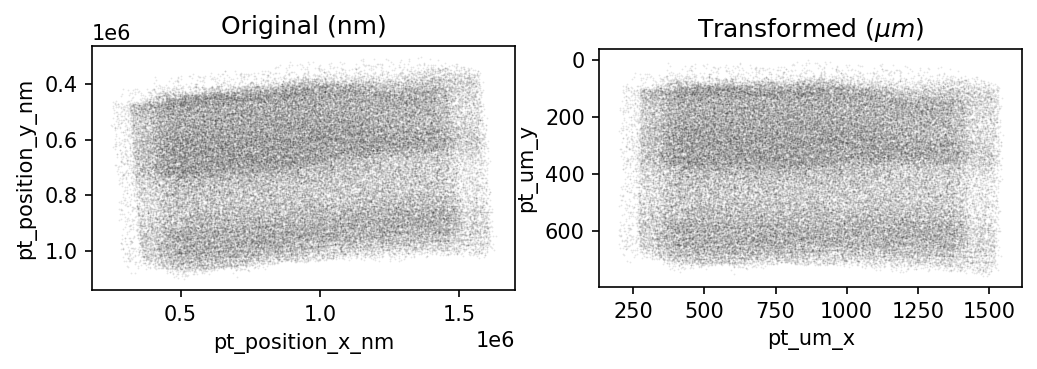

In [33]:
# Compare the original (above) to a transformed (second column)
fig, axes = plt.subplots(figsize=(8,3), ncols=2, dpi=150)
ax = axes[0]
sns.scatterplot(
    x='pt_position_x_nm',
    y='pt_position_y_nm',
    data=soma_df,
    s=0.75,
    alpha=0.1,
    color='k',
    ax=ax,
)
ax.invert_yaxis()
ax.set_aspect('equal')
ax.set_title('Original (nm)')

ax = axes[1]
sns.scatterplot(
    x='pt_um_x',
    y='pt_um_y',
    data=soma_df,
    s=0.75,
    alpha=0.1,
    color='k',
    ax=ax,
)

ax.invert_yaxis()
ax.set_aspect('equal')

_ = ax.set_title('Transformed ($\mu m$)')

### Soma depths and cell types

You can use the optional argument `projection="y"` for the function `minnie_ds.transform_vx.apply_dataframe` to get just the soma depth value and assign it to a column.

**Question**
What excitatory cell types overlap one another most in depth?

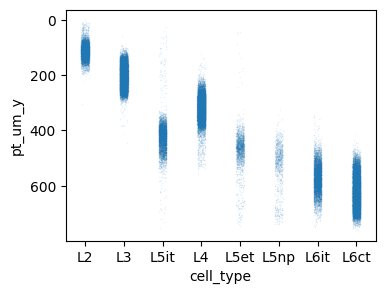

In [40]:
# There are lots of ways to do this

fig, ax = plt.subplots(figsize=(4,3))
sns.stripplot(
    x='cell_type',
    y='pt_um_y',
    data=soma_df.query('classification_system == "excitatory_neuron"'),
    ax=ax,
    s=1,
    alpha=0.1,
)

ax.invert_yaxis()

## Different visual areas

The MICrONs dataset was taken at the edge of primary visual cortex and higher visual areas RL and AL.
We will now look at how cells might differ between primary and higher-order regions.
A function that returns True if a location is beyond a linear approximation of the HVAs and False otherwise.

**Task**

Using the code below, determine if each cell body is a in the HVA or not.

In [52]:

# These values come from a linear approximation of primary visual cortex/HVA
# boundaries in *voxels* before transformation. Make sure to convert units if you want. 
xz0 = [237415, 26308]
xz1 = [286783, 8960]

x0 = xz0[0]
x1 = xz1[0]
z0 = xz0[1]
z1 = xz1[1]

def soma_in_hva(pt):
    ptx = pt.iloc[0]
    ptz = pt.iloc[1]
    x_thresh = x1 + (ptz-z1) * (x0-x1) / (z0-z1)
    return ptx > x_thresh

soma_df['in_hva'] = soma_df[['pt_position_x', 'pt_position_z']].apply(soma_in_hva, axis=1)

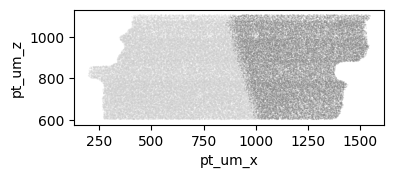

In [53]:
fig, ax = plt.subplots(figsize=(4,3))

sns.scatterplot(
    x='pt_um_x',
    y='pt_um_z',
    data=soma_df,
    hue='in_hva',
    s=1,
    palette='Greys',
    alpha=0.2,
    legend=False,
)

ax.set_aspect('equal')

**Tasks**
1) For some location in primary visual cortex and some location in an HVA, compute the excitatory cell density measuring number of cells per unit volume as a function of depth. Depth bins or windows around 30-50 microns work well. Plot a comparison of the cell density profile of the HVA to VISp.

2) Compare the relative fraction of excitatory neurons with different cell types. What cell types are much more common in the HVA and which less common?

In [54]:
def get_z_slice( depth, pts, bin_height=10):
    return np.logical_and(pts[:,1] > depth-bin_height/2, pts[:,1] <= depth+bin_height/2)

def get_radius(ctr_pt, pts):
    return np.linalg.norm(pts[:,[0,2]] - np.array(ctr_pt), axis=1)

def num_within_disk(ctr_pt, depths, pts, width=30, bin_height=10):
    ctr_pt = np.array(ctr_pt)
    r = get_radius(
        ctr_pt,
        pts,
    )
    return np.array([np.logical_and(r < width, get_z_slice(d, pts, bin_height)).sum() for d in depths])

def cell_density(
    ctr_pt,
    depths,
    soma_df,
    width=100,
    bin_height=25,
    position_cols = ['pt_um_x', 'pt_um_y', 'pt_um_z'],
):
    pts = np.vstack(soma_df[position_cols].values)
    n_cells = num_within_disk(
        ctr_pt,
        depths,
        pts,
        width=width,
        bin_height=bin_height,
    )
    disk_volume_um = np.pi*width**2*bin_height
    return n_cells / disk_volume_um * 1_000_000

In [58]:
visp_pt = (700, 850)
hva_pt = (1100, 850)
depths = np.linspace(0,800,100)

In [67]:
visp_density = cell_density(
    visp_pt, 
    depths,
    soma_df.query('classification_system == "excitatory_neuron"'),
    width=150,
    bin_height=40,
)

hva_density = cell_density(
    hva_pt,
    depths,soma_df.query('classification_system == "excitatory_neuron"'),
    width=150,
    bin_height=40,
)

In [81]:
hva_soma = soma_df.query(
    'classification_system=="excitatory_neuron" and in_hva'
).value_counts('cell_type')

visp_soma = soma_df.query(
    'classification_system=="excitatory_neuron" and not in_hva'
).value_counts('cell_type')

ct_frac_df = pd.DataFrame(
    {
        'hva': hva_soma / sum(hva_soma),
        'visp': visp_soma / sum(visp_soma),
    }
)

((ct_frac_df['hva'] - ct_frac_df['visp']) / (ct_frac_df['visp'])).reset_index().rename(columns={0: 'delta_population_fraction'})

,cell_type,delta_population_fraction
0,L2,-0.297402
1,L3,0.035382
2,L4,-0.178578
3,L5et,0.325878
4,L5it,0.204820
5,L5np,0.005970
6,L6ct,0.086871
7,L6it,0.440240


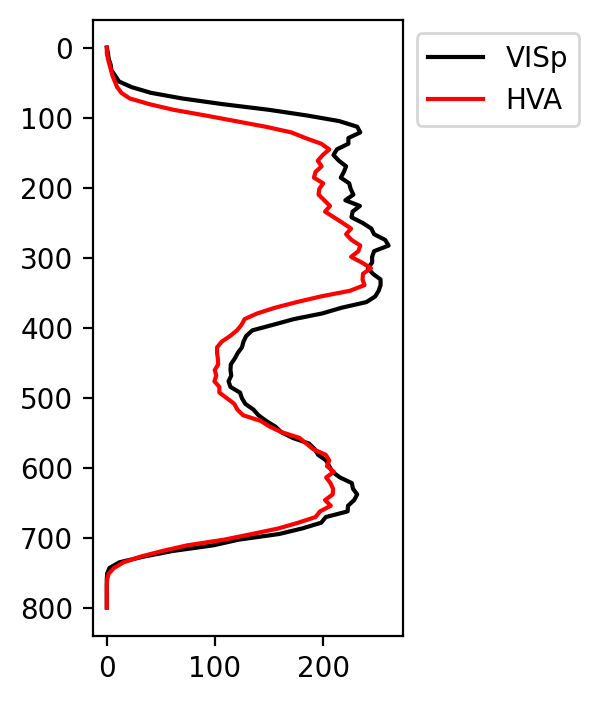

In [68]:
fig, ax = plt.subplots(
    figsize=(2,4),
    dpi=200,
)

ax.plot(visp_density, depths, color='k',)
ax.plot(hva_density, depths, color='r',)

ax.invert_yaxis()
ax.legend(['VISp', 'HVA']).set_bbox_to_anchor((1,1))


# Extra Credit!

As a bonus to help think about the data if you would like, I've pre-computed density profiles every 10 microns through a region along the center of the dataset.
This exercise is purely optional.
Using whatever data analysis technique you can think of, what areas of the data have similar density profiles?
How do these match with the VISp/HVA boundary?

The code used to compute density is shown below and the file is in this directory as `density_profile.feather`.
You can load this file with `profile_df = pd.read_feather('density_profile.feather')`.



```python
xvals = np.arange(450, 1301, 10)
zvals = np.arange(650, 1051, 10)

depths = np.linspace(0,800,100)

profiles = []
xloc = []
zloc = []
for xx in tqdm(xvals):
    for zz in zvals:
        profiles.append(
            cell_density(
                (xx, zz),
                depths,
                soma_df.query('classification_system == "excitatory_neuron"'),
                bin_height=40,
                width=50,
            )
        )
        xloc.append(xx)
        zloc.append(zz)

profile_df = pd.DataFrame(
    {
        "xloc": xloc,
        "zloc": zloc,
        "profile": profiles
    }
)

data_df = {"xloc": xloc, "zloc": zloc}
profiles = np.array(profiles)
profile_cols = []
for ii in range(profiles.shape[1]):
    data_df[f"dep_dens_{ii}"] = profiles[:,ii]
    profile_cols.append(f"dep_dens_{ii}")

profile_df = pd.DataFrame(data_df)
```

In [69]:
# Load the file described above 
profile_df = pd.read_feather('../data/density_profile.feather')